# Running a random forest model on the data #

**Comment:** <br>
Here a random forest model will be trained where we can use the OOB error to tune the parameters of the model.

## Load data 

In [1]:
import pandas as pd
import sklearn
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import math
import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('../Spotify_v3.csv', sep = ';')
df.head()

,Unnamed: 0,title,artist,top genre,year,added,bpm,nrgy,dnce,dB,...,val,dur,acous,spch,pop,title_core,lyrics,lyric_pos_sent,lyric_neg_sent,Pos/Neg
0,0,It's You - Radio Edit,Syn Cole,big room,2015,2017‑10‑07,128,83,65,-4,...,49,212,11,5,58,It's You,"[Verse 1: Syn Cole]\r\nPaints like a picture, ...",0.191,0.100,1
1,1,Show You Love,Kato,danish hip hop,2017,2018‑10‑25,124,83,69,-5,...,66,183,29,7,47,Show You Love,[Verse 1: Hailee Steinfeld]\r\nI'll do this th...,0.363,0.025,1
2,2,Just Us,Said the Sky,chillstep,2018,2019‑02‑28,109,58,75,-5,...,33,163,19,6,68,Just Us,[Verse 1]\r\nBeen so long\r\nSince I had someo...,0.050,0.041,1
3,3,Warriors - Rob Adans Remix,Nicky Romero,big room,2015,2017‑05‑17,127,89,67,-3,...,65,312,0,4,36,Warriors,[Verse]\r\nEmerging from the dust and rubble\r...,0.000,0.111,0
4,4,The Sweet Escape,Gwen Stefani,australian pop,2006,2016‑01‑08,120,77,75,-3,...,74,246,21,3,66,The Sweet Escape,"[Intro: Akon]\r\nKonvict, Konvict, Konvict\r\n...",0.123,0.127,0


In [3]:
# Change outcome variable to be between -1 and 1 #
df['Pos/Neg'] = 1*df['lyric_pos_sent']*(df['Pos/Neg'] == 1) + (-1)*df['lyric_neg_sent']*(df['Pos/Neg'] == 0)

# Drop NaN rows #
df = df.dropna(axis = 0)

# Scale output between 0 and 1
x = df[['Pos/Neg']].values.astype(float)

min_max_scaler = MinMaxScaler()

x_scaled = min_max_scaler.fit_transform(x)

df['Pos/Neg'] = x_scaled

In [4]:
# Get the variables that are used as X variables #
X = df[['bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur', 'acous','spch', 'pop']]
Y = df['Pos/Neg']

In [5]:
for var in ['bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur', 'acous', 'spch', 'pop']:
    print('%s: [Min = %s, Max = %s]' % (var, df[var].min(), df[var].max()))
    print('\r')

bpm: [Min = 49, Max = 204]

nrgy: [Min = 0, Max = 99]

dnce: [Min = 7, Max = 97]

dB: [Min = -36, Max = -1]

live: [Min = 2, Max = 97]

val: [Min = 3, Max = 97]

dur: [Min = 58, Max = 695]

acous: [Min = 0, Max = 100]

spch: [Min = 2, Max = 62]

pop: [Min = 0, Max = 98]



## Split into training and test data 

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 7)

## Tune the Random Forest model

In [8]:
from sklearn.ensemble import RandomForestRegressor

# Tune the number of variables to consider in each split #
OOB_score = {}
for i in range(1, X.shape[1] + 1):
    RF_regr = RandomForestRegressor(min_samples_leaf = 5, random_state=0, n_estimators = 1000,
                            criterion = 'mse', max_features = i, n_jobs = -1, oob_score = True)
    RF_regr.fit(X_train, Y_train)
    
    OOB_score[i] = RF_regr.oob_score_
    
min(OOB_score, key=OOB_score.get)

10

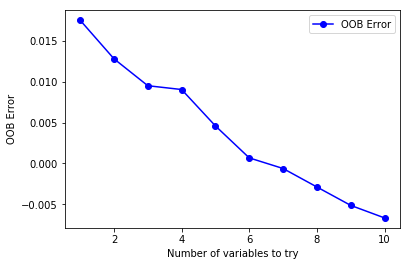

In [9]:
plt.plot([i for i in range(1, 11)], OOB_score.values(), '-bo', label = 'OOB Error');
plt.xlabel('Number of variables to try');
plt.ylabel('OOB Error');
plt.legend(loc = 'upper right');
plt.show()

**Comment:** <br>
This is almost equivalent to the maximum number of parameters that is allowed, which in this case `10`. Here the optimal number of variables to consider at each split is found to be `10`.

Here we consider the OOB error which is approximately the test error.

One can also train the number of data points there needs to be in the leafs, but this is usally 5 in regression and 1 in the classification example respectively.


## Train the Random Forest model best on the optimal number of variables at each split

In [10]:
model_opt = RandomForestRegressor(min_samples_leaf = 5, random_state=0, n_estimators = 1000,
                            criterion = 'mse', max_features = min(OOB_score, key=OOB_score.get), n_jobs = -1, oob_score = True)
model_opt.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=True, random_state=0,
           verbose=0, warm_start=False)

## Check the model

In [11]:
model_opt.feature_importances_

array([0.11372531, 0.09225547, 0.11514673, 0.04952784, 0.1151354 ,
       0.12921783, 0.11531586, 0.09169677, 0.07831527, 0.09966353])

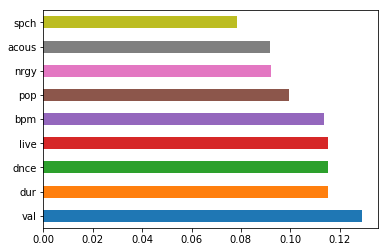

In [12]:
feat_importances = pd.Series(model_opt.feature_importances_, index=X.columns)
feat_importances.nlargest(9).plot(kind='barh');

**Comment:** <br>
Here it is seen that `val = valence` is the most important parameter in explaining the `mood score`.

In [13]:
print('Optimal out of bag error = %s' % round(model_opt.oob_score_, 7))

Optimal out of bag error = -0.006654


## Computing test error (Test MSE)

In [14]:
def TestMSE(Y_test, Y_pred):
    '''
    Input: Array/List of Test set Y values and array of test set Y predictions.
    Output: TestMSE
    '''
    
    Y_test = np.array(Y_test)
    Y_pred = np.array(Y_pred)
    
    Sq_err = []
    
    for Y, pred in zip(Y_test, Y_pred):
        Sq_err.append( (Y - pred) ** 2 )
        
    Mean_sq_err = np.mean(Sq_err)
    
    return Mean_sq_err

In [15]:
# Predict for the Test values #

Y_pred = model_opt.predict(X_test)

# Calculate the Test MSE #
Test_MSE_Rf = TestMSE(Y_test, Y_pred)

print('Test MSE for the Random forest model = %s' % round(Test_MSE_Rf, 5))

Test MSE for the Random forest model = 0.01149


## Linear regression

In [16]:
# Import package #
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [17]:
# Predict with the linear regression model #
Y_pred_lm = lm.predict(X_test)

# Calculate Test MSE for the linear regression model #
Test_MSE_lm = TestMSE(Y_test, Y_pred_lm)

print('Test MSE for the linear regression model = %s' % round(Test_MSE_lm, 5))

Test MSE for the linear regression model = 0.01212


**Comment:** <br>
We see that the Random forest is slightly better.

## Random forest Pickle

In [18]:
import pickle

In [19]:
Rf_model = RandomForestRegressor(min_samples_leaf = 5, random_state=0, n_estimators = 1000,
                            criterion = 'mse', max_features = min(OOB_score, key=OOB_score.get), n_jobs = -1, oob_score = True)
Rf_model.fit(X, Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=True, random_state=0,
           verbose=0, warm_start=False)

In [20]:
filename = 'Rf_model.pickle'

pickle_out = open(filename, 'wb')

pickle.dump(Rf_model, pickle_out)
pickle_out.close()